# Hand Gesture Classification


## Imports

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import random

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay

import sys
import os

# Add src/ to the Python path
sys.path.append(os.path.abspath("../src"))

# local modules
from mlflow_logger import log_to_mlflow
from helpers import calculate_metrics, show_metrics
from preprocessing import preprocessing

px.defaults.color_discrete_sequence = px.colors.qualitative.Bold

## Data Loading and Exploration

In [2]:
df = pd.read_csv(r'../data/hand_landmarks_data.csv')
df.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call
3,114.976696,331.594238,-1.233261e-07,114.503494,320.549957,-0.002824,116.636627,310.080994,-0.008911,117.685066,...,145.195450,329.357544,-0.027622,151.053200,329.712341,-0.027863,155.990364,329.548828,-0.027723,call
4,188.795288,141.727867,-1.622995e-07,188.520905,127.947464,-0.002884,191.982880,111.010563,-0.008115,192.552521,...,226.696396,132.263248,-0.025113,234.831741,130.684147,-0.024087,241.587769,128.477188,-0.023486,call


In [3]:
df.shape

(25675, 64)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25675 entries, 0 to 25674
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      25675 non-null  float64
 1   y1      25675 non-null  float64
 2   z1      25675 non-null  float64
 3   x2      25675 non-null  float64
 4   y2      25675 non-null  float64
 5   z2      25675 non-null  float64
 6   x3      25675 non-null  float64
 7   y3      25675 non-null  float64
 8   z3      25675 non-null  float64
 9   x4      25675 non-null  float64
 10  y4      25675 non-null  float64
 11  z4      25675 non-null  float64
 12  x5      25675 non-null  float64
 13  y5      25675 non-null  float64
 14  z5      25675 non-null  float64
 15  x6      25675 non-null  float64
 16  y6      25675 non-null  float64
 17  z6      25675 non-null  float64
 18  x7      25675 non-null  float64
 19  y7      25675 non-null  float64
 20  z7      25675 non-null  float64
 21  x8      25675 non-null  float64
 22

In [5]:
labels = df['label'].unique()
labels_freq = df['label'].value_counts().to_list()
fig = px.bar(x=labels, y=labels_freq, labels='freq')
fig.update_layout(
    xaxis_title="Gesture Label",
    yaxis_title="Frequency"
)
fig.update_traces(
    hovertemplate="Label: %{x}<br>Frequency: %{y}<extra></extra>"
)
fig.update_traces(opacity=0.7)
fig.show()

In [6]:
print(f"There are {len(labels)} Classes")

There are 18 Classes


### 2D Gestures visualization

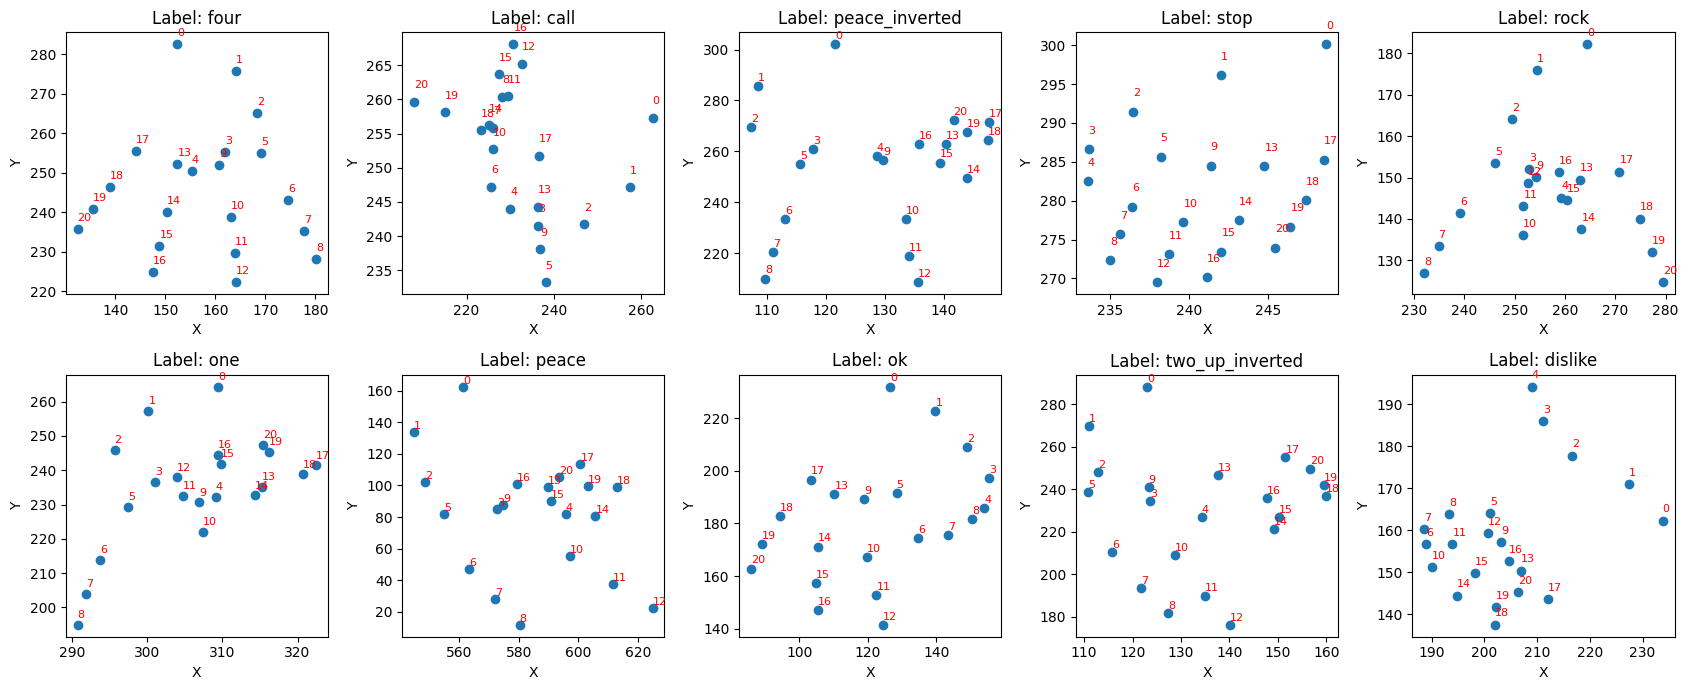

In [7]:
import random
import matplotlib.pyplot as plt
import numpy as np

rand_labels = random.sample(population=labels.tolist(), k=10)
samples = []

# Set figure size first
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(17, 7))

for i, label in enumerate(rand_labels):
    # Select first record for the current label
    sample = df[df["label"] == label].iloc[0][:-1].to_numpy(dtype=float)
    samples.append(sample)

samples = np.array(samples)
samples = samples.reshape((10, 21, 3))  # (num_samples, num_points, xyz)

for idx, record in enumerate(samples):
    x = record[:, 0]
    y = record[:, 1]
    z = record[:, 2]
    
    row = idx // 5
    col = idx % 5
    axs[row, col].scatter(x, y)
    
    # Annotate each point
    for point_idx, (xi, yi) in enumerate(zip(x, y)):
        axs[row, col].text(xi, yi+2, str(point_idx), fontsize=8, color='red')
    
    axs[row, col].set_title(f"Label: {rand_labels[idx]}")
    axs[row, col].set_xlabel("X")
    axs[row, col].set_ylabel("Y")

plt.tight_layout()
plt.show()

### 3D Gestures visualization

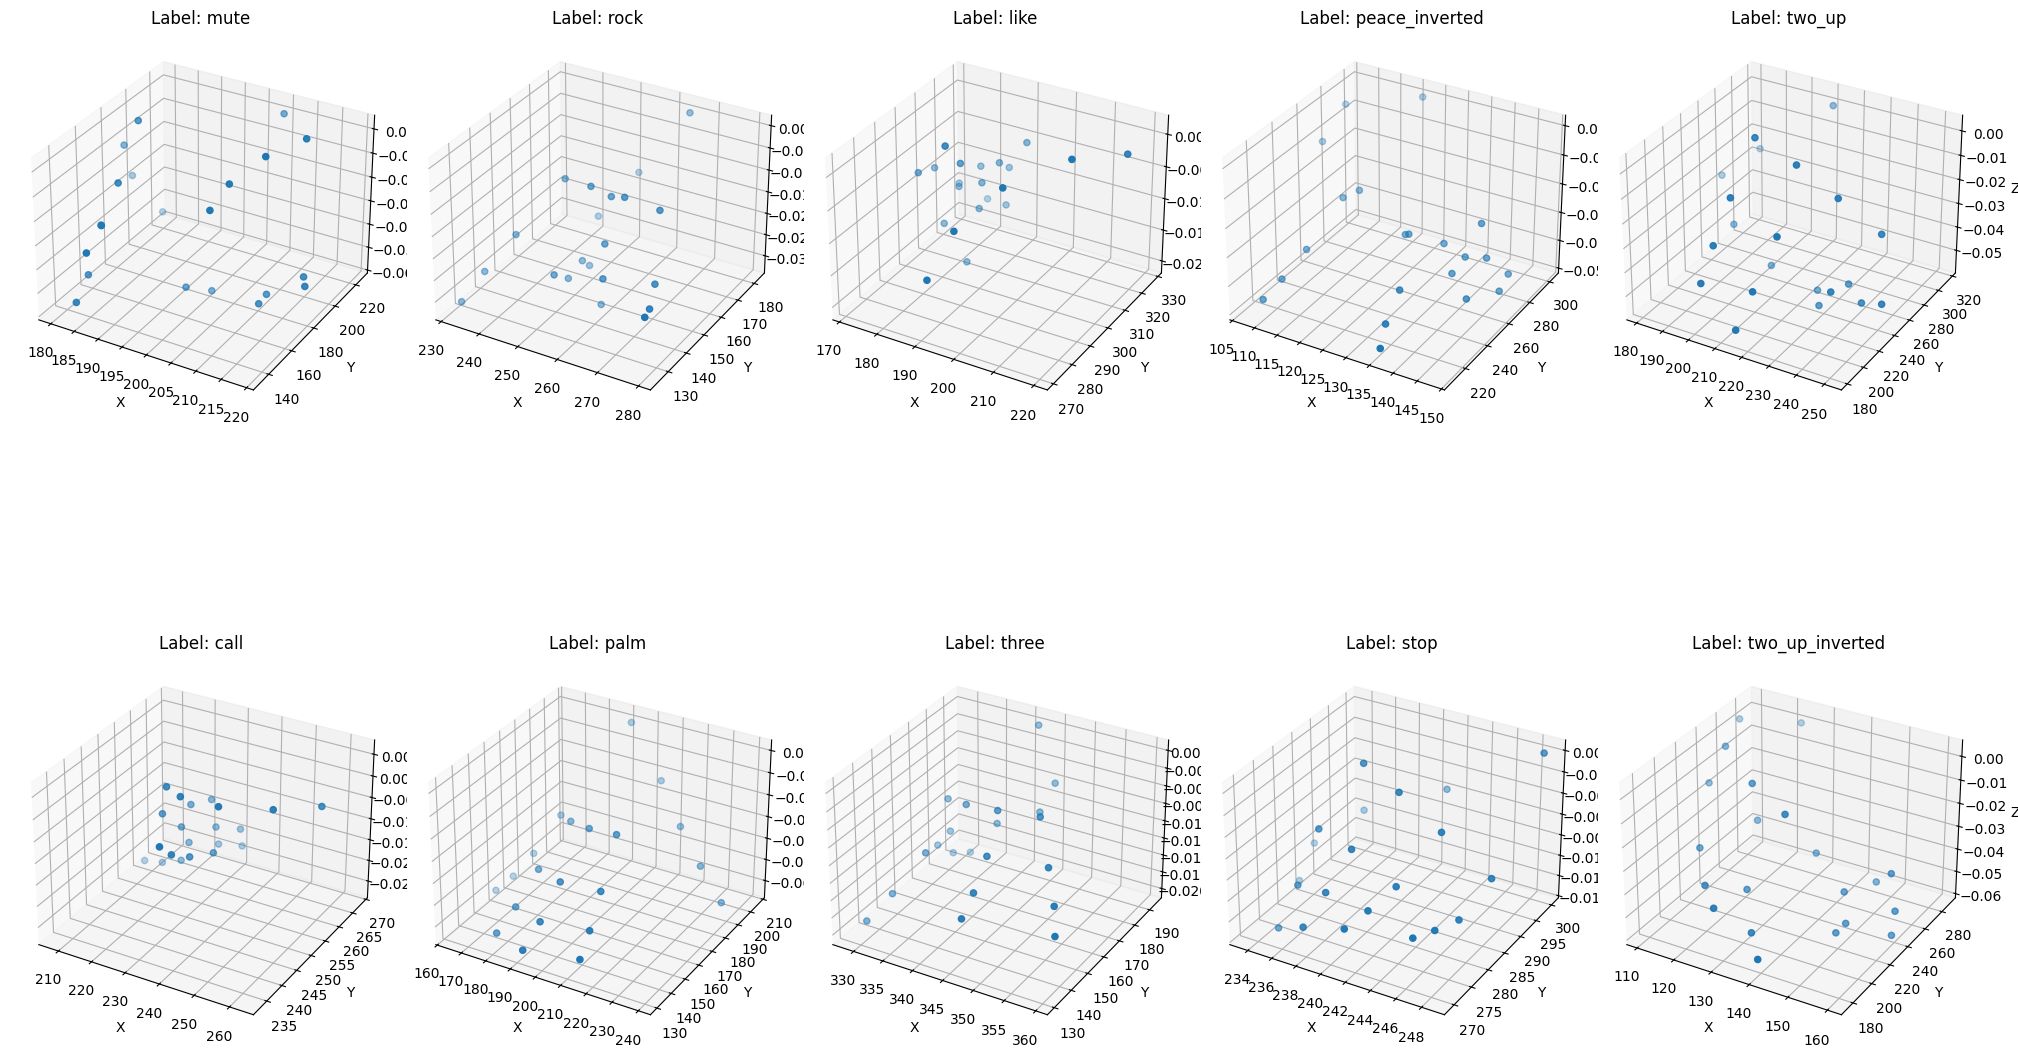

In [8]:
import random
import matplotlib.pyplot as plt
import numpy as np
# from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting

rand_labels = random.sample(population=labels.tolist(), k=10)
samples = []

# Select first record for each random label
for label in rand_labels:
    sample = df[df["label"] == label].iloc[0][:-1].to_numpy(dtype=float)
    samples.append(sample)

samples = np.array(samples)
samples = samples.reshape((10, 21, 3))  # (num_samples, num_points, xyz)

# Create subplots
fig = plt.figure(figsize=(20, 15))

for idx, record in enumerate(samples):
    ax = fig.add_subplot(2, 5, idx + 1, projection='3d')  # 2 rows, 5 cols
    x = record[:, 0]
    y = record[:, 1]
    z = record[:, 2]
    
    ax.scatter(x, y, z)
    ax.set_title(f"Label: {rand_labels[idx]}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

plt.tight_layout()
plt.show()

## Data Preprocessing

In [9]:
# checking for duplicates
df.duplicated().sum()

0

In [10]:
# checking for nans
df.isna().sum().sum()

0

In [11]:
# split into train_val and test
X = df.drop('label', axis=1)
y = df['label']
x_train_val, x_test, y_train_val, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)
print(f"shapes x_train: {x_train_val.shape}, x_test: {x_test.shape}, y_train: {y_train_val.shape}, y_test: {y_test.shape}")

shapes x_train: (20540, 63), x_test: (5135, 63), y_train: (20540,), y_test: (5135,)


In [12]:
# split into train and valid
x_train, x_valid, y_train, y_valid = train_test_split(x_train_val, y_train_val, stratify=y_train_val, random_state=42, test_size=0.2)
print(f"shapes x_train: {x_train.shape}, x_test: {x_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

shapes x_train: (16432, 63), x_test: (5135, 63), y_train: (16432,), y_test: (5135,)


In [13]:
x_train_prep = preprocessing(x_train)
x_valid_prep = preprocessing(x_valid)
x_test_prep = preprocessing(x_test)


In [14]:
x_train.shape

(16432, 63)

## Model Training

### Logistic Regression

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegressionCV(multi_class="ovr", solver="liblinear")

logistic.fit(x_train_prep, y_train)
logistic.score(x_valid_prep, y_valid)

c:\Users\lenovo\anaconda3\envs\DEPI\lib\site-packages\sklearn\linear_model\_logistic.py:1914: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.

c:\Users\lenovo\anaconda3\envs\DEPI\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\lenovo\anaconda3\envs\DEPI\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\lenovo\anaconda3\envs\DEPI\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\lenovo\anaconda3\envs\DEPI\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\lenovo\anaconda3\envs\DE

0.9337877312560857

{'accuracy': 0.9343719571567672, 'f1_score': 0.9342314222446882, 'precision': 0.9350274110779854, 'recall': 0.9343719571567672}


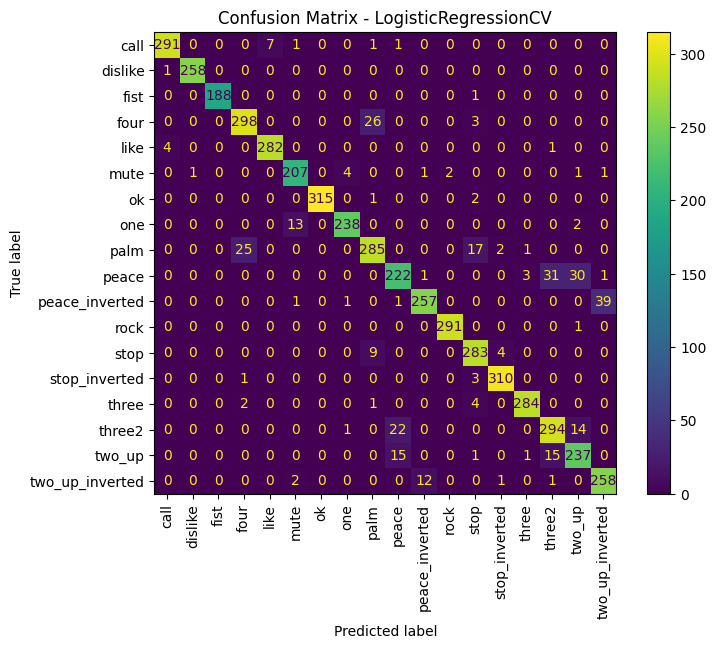

In [16]:
show_metrics(logistic, x_test_prep, y_test)

In [17]:
y_test_pred = logistic.predict(x_test_prep)
log_to_mlflow(
    experiment_name='hand_gestures_classification', 
    run_name='ovr_logistic_cv',
    model=logistic,
    model_path="logistic_regression",  
    metrics=calculate_metrics(y_test, y_test_pred),
    params=logistic.get_params(),
    y_test=y_test,
    y_pred=y_test_pred
)

c:\Users\lenovo\anaconda3\envs\DEPI\lib\site-packages\mlflow\tracking\_tracking_service\utils.py:184: FutureWarning:

The filesystem tracking backend (e.g., './mlruns') is deprecated as of February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://mlflow.org/docs/latest/self-hosting/migrate-from-file-store for migration guidance.

2026/02/23 03:56:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 03:56:59 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Model logged: logistic_regression
Visualization logged: plots/confusion_matrix.png
Session Finished: ovr_logistic_cv (ID: b3e0d1060d2a428381eff4ba36637c72)


### Random Forest

#### With default params

In [18]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(x_train_prep, y_train)

RandomForestClassifier()

{'accuracy': 0.9643622200584225, 'f1_score': 0.9643715953095875, 'precision': 0.9644967681735496, 'recall': 0.9643622200584225}


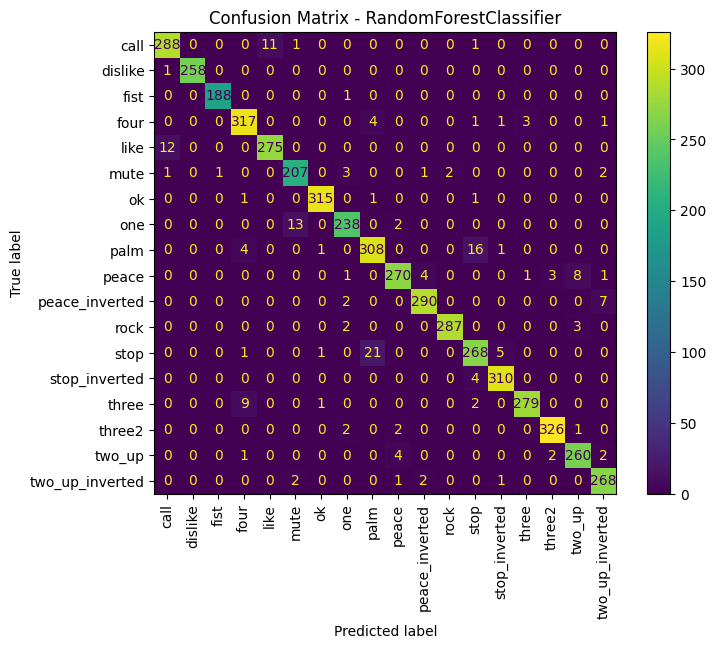

In [19]:
show_metrics(rfc, x_test_prep, y_test)

In [20]:
y_test_pred = rfc.predict(x_test_prep)
log_to_mlflow(
    experiment_name='hand_gestures_classification', 
    run_name='random_forest_default',
    model=rfc,
    model_path="random_forest",  
    metrics=calculate_metrics(y_test, y_test_pred),
    params=rfc.get_params(),
    y_test=y_test,
    y_pred=y_test_pred
)

2026/02/23 03:57:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 03:57:19 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Model logged: random_forest
Visualization logged: plots/confusion_matrix.png
Session Finished: random_forest_default (ID: b10a35dd3eb94d3892e9c0ad987b5404)


### XGboost

In [21]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_valid_encoded = le.transform(y_valid)
y_test_encoded = le.transform(y_test)

In [22]:
xgb = XGBClassifier()
xgb.fit(x_train_prep, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [23]:
y_test_pred = xgb.predict(x_test_prep)
metrics = {
        "accuracy": accuracy_score(y_test_encoded, y_test_pred),
        "f1_score": f1_score(y_test_encoded, y_test_pred, average='weighted'),
        "precision": precision_score(y_test_encoded, y_test_pred, average='weighted'),
        "recall": recall_score(y_test_encoded, y_test_pred, average='weighted')
    }
metrics

{'accuracy': 0.9803310613437196,
 'f1_score': 0.9803498265547226,
 'precision': 0.9804585071840296,
 'recall': 0.9803310613437196}

Text(0.5, 1.0, 'Confusion Matrix - XGBClassifier')

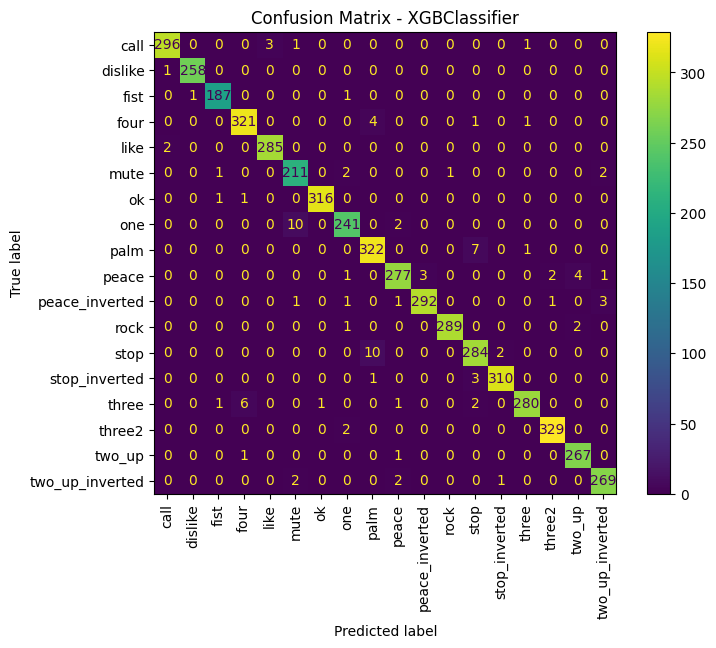

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, le.inverse_transform(y_test_pred), ax=ax, xticks_rotation=90)
ax.set_title(f"Confusion Matrix - {xgb.__class__.__name__}")

In [25]:
y_test_pred = xgb.predict(x_test_prep)
log_to_mlflow(
    experiment_name='hand_gestures_classification', 
    run_name='xgb_default',
    model=xgb,
    model_path="xgb",  
    metrics=calculate_metrics(y_test_encoded, y_test_pred),
    params=xgb.get_params(),
    y_test=le.inverse_transform(y_test_encoded),
    y_pred=le.inverse_transform(y_test_pred)
)

2026/02/23 03:57:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 03:57:28 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Model logged: xgb
Visualization logged: plots/confusion_matrix.png
Session Finished: xgb_default (ID: 2288d1c272ca49a989b57eb5ac63714a)


### SVM

#### SVM kernel='poly' degree=3

In [26]:
from sklearn.svm import SVC

svc = SVC(kernel='poly', decision_function_shape='ovo')
svc.fit(x_train_prep, y_train)

SVC(decision_function_shape='ovo', kernel='poly')

{'accuracy': 0.8373904576436222, 'f1_score': 0.8366784809155065, 'precision': 0.8491625256146544, 'recall': 0.8373904576436222}


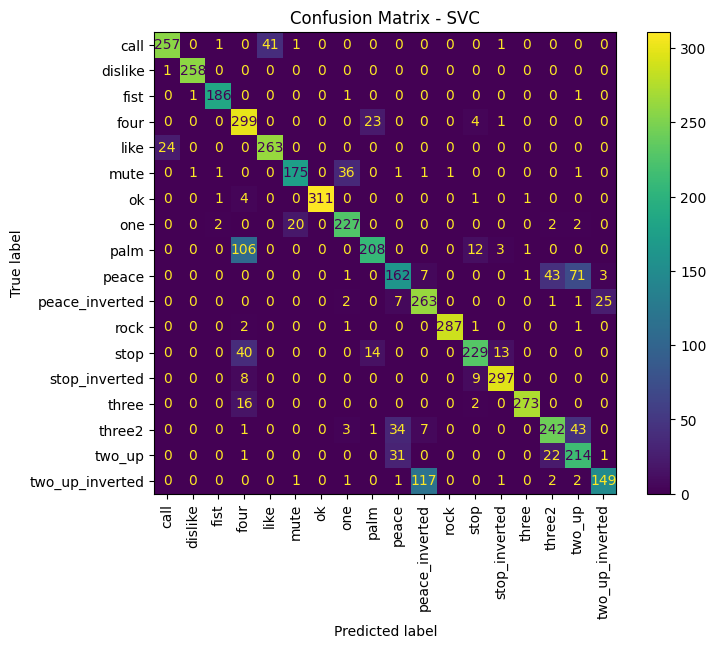

In [27]:
show_metrics(svc, x_test_prep, y_test)

In [28]:
y_test_pred = svc.predict(x_test_prep)
log_to_mlflow(
    experiment_name='hand_gestures_classification', 
    run_name='svc_poly_ovo_d3',
    model=svc,
    model_path="svc",  
    metrics=calculate_metrics(y_test, y_test_pred),
    params=svc.get_params(),
    y_test=y_test,
    y_pred=y_test_pred
)

2026/02/23 03:57:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 03:57:40 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Model logged: svc
Visualization logged: plots/confusion_matrix.png
Session Finished: svc_poly_ovo_d3 (ID: 714e061b1e494c7fb38b8e0766e0b48b)


#### SVM kernel='poly' degree=5

In [29]:
svc = SVC(kernel='poly', decision_function_shape='ovo', degree=5)
svc.fit(x_train_prep, y_train)

SVC(decision_function_shape='ovo', degree=5, kernel='poly')

{'accuracy': 0.9279454722492697, 'f1_score': 0.9285101641257046, 'precision': 0.9321534498932889, 'recall': 0.9279454722492697}


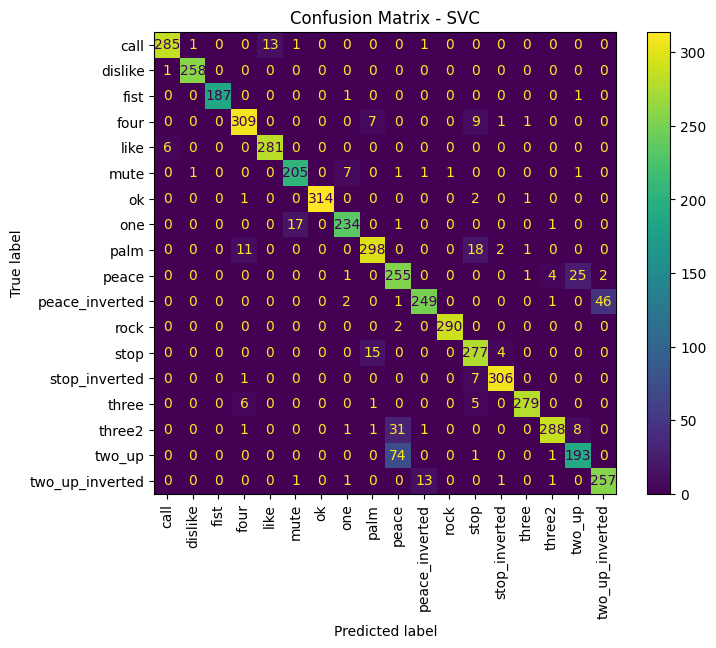

In [30]:
show_metrics(svc, x_test_prep, y_test)

In [31]:
y_test_pred = svc.predict(x_test_prep)
log_to_mlflow(
    experiment_name='hand_gestures_classification', 
    run_name='svc_poly_ovo_d5',
    model=svc,
    model_path="svc",  
    metrics=calculate_metrics(y_test, y_test_pred),
    params=svc.get_params(),
    y_test=y_test,
    y_pred=y_test_pred
)

2026/02/23 03:57:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 03:57:49 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Model logged: svc
Visualization logged: plots/confusion_matrix.png
Session Finished: svc_poly_ovo_d5 (ID: 7bdb827c26b64e808b533fd966432b90)


#### SVM kernel='poly' degree=10

In [32]:
svc = SVC(kernel='poly', decision_function_shape='ovo', degree=10)
svc.fit(x_train_prep, y_train)

SVC(decision_function_shape='ovo', degree=10, kernel='poly')

{'accuracy': 0.9737098344693281, 'f1_score': 0.9737750907579831, 'precision': 0.9739760672697884, 'recall': 0.9737098344693281}


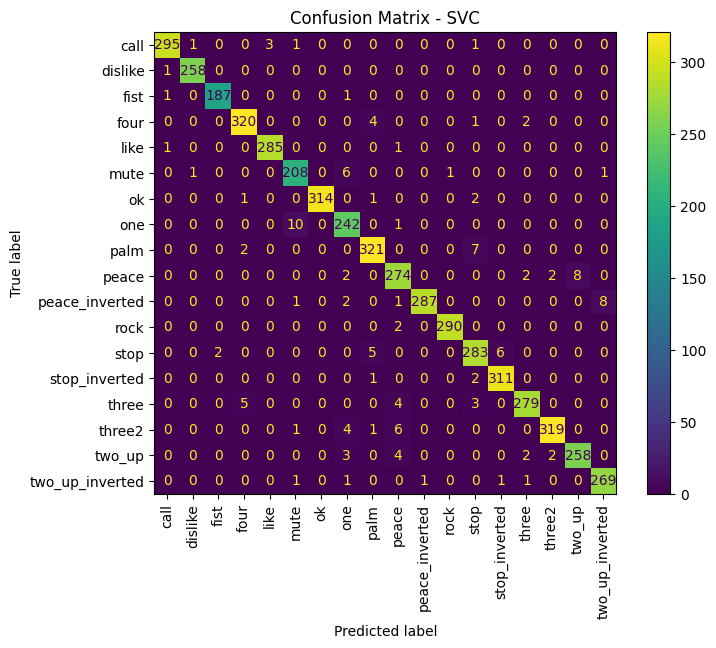

In [33]:
show_metrics(svc, x_test_prep, y_test)

In [34]:
y_test_pred = svc.predict(x_test_prep)
log_to_mlflow(
    experiment_name='hand_gestures_classification', 
    run_name='svc_poly_ovo_d10',
    model=svc,
    model_path="svc",  
    metrics=calculate_metrics(y_test, y_test_pred),
    params=svc.get_params(),
    y_test=y_test,
    y_pred=y_test_pred
)

2026/02/23 03:57:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 03:57:58 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Model logged: svc
Visualization logged: plots/confusion_matrix.png
Session Finished: svc_poly_ovo_d10 (ID: 1d345d4e92674c68bb7781c5027765b7)


#### SVM kernel='poly' degree=15

In [35]:
svc = SVC(kernel='poly', decision_function_shape='ovo', degree=15)
svc.fit(x_train_prep, y_train)

SVC(decision_function_shape='ovo', degree=15, kernel='poly')

{'accuracy': 0.9733203505355404, 'f1_score': 0.9733908511804346, 'precision': 0.9735492627748258, 'recall': 0.9733203505355404}


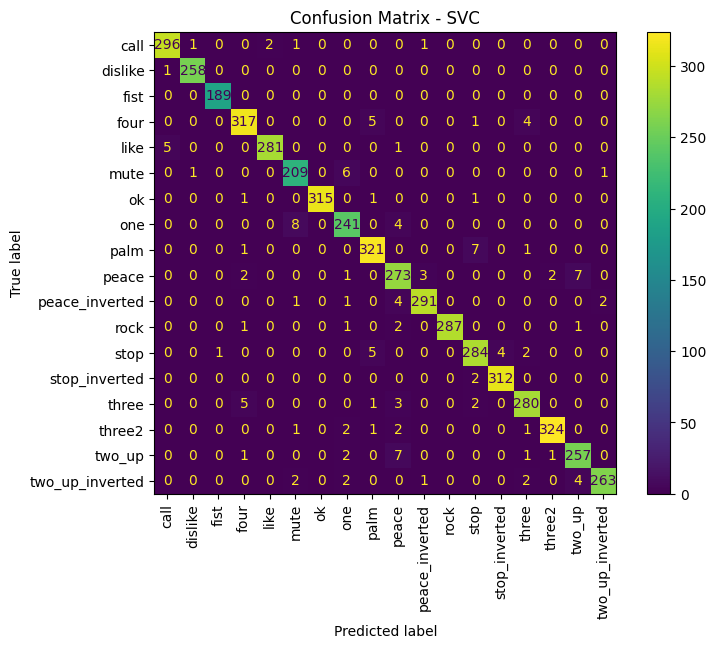

In [36]:
show_metrics(svc, x_test_prep, y_test)

In [37]:
y_test_pred = svc.predict(x_test_prep)
log_to_mlflow(
    experiment_name='hand_gestures_classification', 
    run_name='svc_poly_ovo_d15',
    model=svc,
    model_path="svc",  
    metrics=calculate_metrics(y_test, y_test_pred),
    params=svc.get_params(),
    y_test=y_test,
    y_pred=y_test_pred
)

2026/02/23 03:58:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 03:58:20 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Model logged: svc
Visualization logged: plots/confusion_matrix.png
Session Finished: svc_poly_ovo_d15 (ID: 74e9b93250e340bbb7f3fcb373ed6071)


#### SVM kernel='rbf' 

##### First Try

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svc = SVC(kernel='rbf')

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 0.01, 1],
    'decision_function_shape': ['ovo', 'ovr']
}

grid = GridSearchCV(
    svc, 
    param_grid, 
    cv=3,           
    verbose=2, 
    n_jobs=-1
)

grid.fit(x_train_prep, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': ['scale', 'auto', 0.1, 0.01, 1]},
             verbose=2)

{'accuracy': 0.966699123661149, 'f1_score': 0.9667539981309411, 'precision': 0.9671488722589798, 'recall': 0.966699123661149}


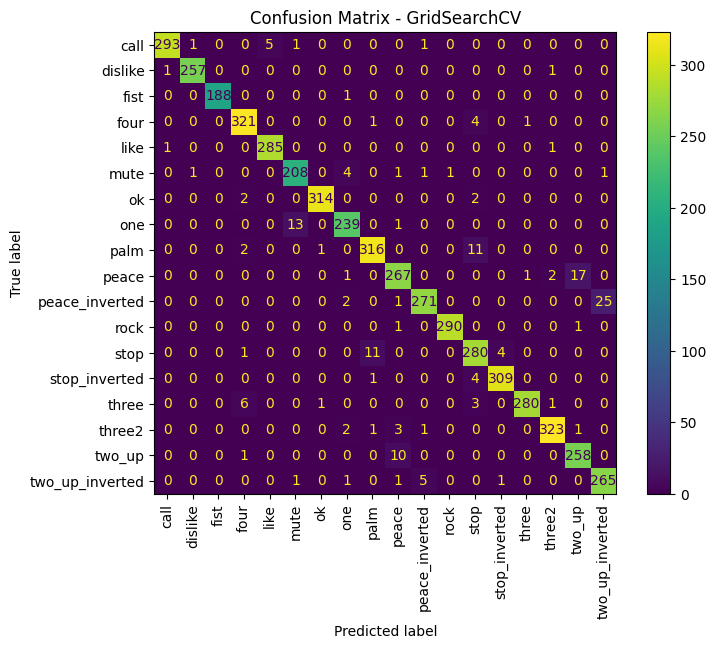

In [40]:
show_metrics(grid, x_test_prep, y_test)

In [41]:
y_test_pred = grid.predict(x_test_prep)
log_to_mlflow(
    experiment_name='hand_gestures_classification', 
    run_name='gridsearch_svc_C10_ovo_gamma1',
    model=grid,
    model_path="gridsearch_svc",  
    metrics=calculate_metrics(y_test, y_test_pred),
    params=grid.get_params(),
    y_test=y_test,
    y_pred=y_test_pred
)

2026/02/23 04:08:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 04:08:15 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Model logged: gridsearch_svc
Visualization logged: plots/confusion_matrix.png
Session Finished: gridsearch_svc_C10_ovo_gamma1 (ID: 2e3ab7b2ebb844e1b314d4f0cdd197ef)


##### Second Try

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svc = SVC(kernel='rbf', decision_function_shape='ovo')

param_grid = {
    'C': [10, 15, 20],
    'gamma': [1, 5, 10], 
}


grid = GridSearchCV(
    svc, 
    param_grid, 
    cv=3,            
    verbose=2, 
    n_jobs=-1
)

grid.fit(x_train_prep, y_train)

print(f"Best Params: {grid.best_params_}")


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Params: {'C': 20, 'gamma': 1}


{'accuracy': 0.9717624148003895, 'f1_score': 0.9717878872519364, 'precision': 0.9720554991355556, 'recall': 0.9717624148003895}


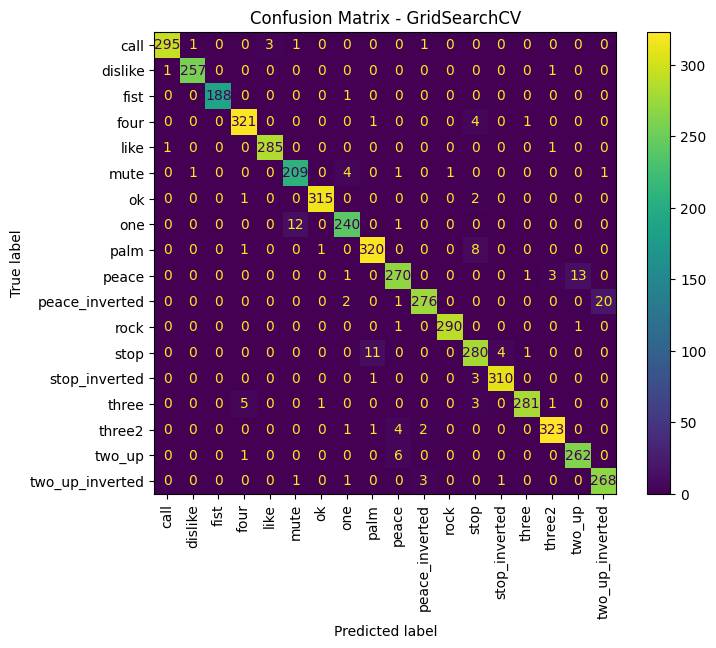

In [45]:
show_metrics(grid, x_test_prep, y_test)

In [46]:
y_test_pred = grid.predict(x_test_prep)
log_to_mlflow(
    experiment_name='hand_gestures_classification', 
    run_name='gridsearch_svc_C20_ovo_gamma1',
    model=grid,
    model_path="gridsearch_svc",  
    metrics=calculate_metrics(y_test, y_test_pred),
    params=grid.get_params(),
    y_test=y_test,
    y_pred=y_test_pred
)

2026/02/23 04:12:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 04:12:07 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Model logged: gridsearch_svc
Visualization logged: plots/confusion_matrix.png
Session Finished: gridsearch_svc_C20_ovo_gamma1 (ID: 1f30ed0f91ba4f4ca80ab2d1fd9099ff)


##### Third Try

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svc = SVC(kernel='rbf', decision_function_shape='ovo')

param_grid = {
    'C': [20, 25, 30],
    'gamma': [1, 2, 3],
}

grid = GridSearchCV(
    svc, 
    param_grid, 
    cv=3,         
    verbose=2, 
    n_jobs=-1
)

grid.fit(x_train_prep, y_train)
print(f"Best Params: {grid.best_params_}")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Params: {'C': 30, 'gamma': 2}


{'accuracy': 0.9764362220058422, 'f1_score': 0.9764754614156061, 'precision': 0.9766114787125245, 'recall': 0.9764362220058422}


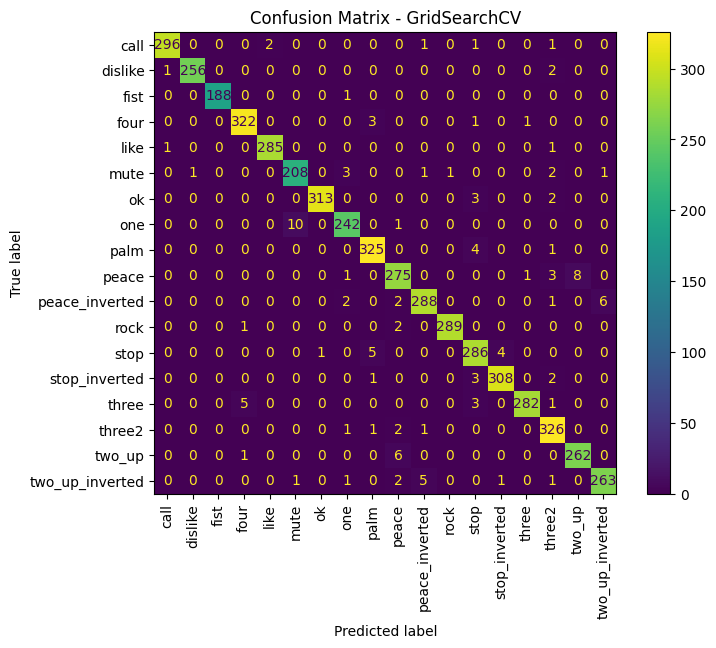

In [48]:
show_metrics(grid, x_test_prep, y_test)

In [49]:
y_test_pred = grid.predict(x_test_prep)
log_to_mlflow(
    experiment_name='hand_gestures_classification', 
    run_name='gridsearch_svc_C30_ovo_gamma2',
    model=grid,
    model_path="gridsearch_svc",  
    metrics=calculate_metrics(y_test, y_test_pred),
    params=grid.get_params(),
    y_test=y_test,
    y_pred=y_test_pred
)

2026/02/23 04:12:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 04:12:27 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Model logged: gridsearch_svc
Visualization logged: plots/confusion_matrix.png
Session Finished: gridsearch_svc_C30_ovo_gamma2 (ID: a288fce212c94d86b6ed5d4264e29b0f)


## Conclusion

| Run Name                         | Model                | Accuracy   | F1 Score   | Precision  | Recall     |
|----------------------------------|----------------------|------------|------------|------------|------------|
| xgb_default                      | XGBoost              | 0.98033    | 0.98035    | 0.98046    | 0.98033    |
| gridsearch_svc_C30_ovo_gamma2    | SVC (GridSearch)     | 0.97644    | 0.97648    | 0.97661    | 0.97644    |
| svc_poly_ovo_d10                 | SVC (Poly, d=10)     | 0.97371    | 0.97378    | 0.97398    | 0.97371    |
| svc_poly_ovo_d15                 | SVC (Poly, d=15)     | 0.97332    | 0.97339    | 0.97355    | 0.97332    |
| gridsearch_svc_C20_ovo_gamma1    | SVC (GridSearch)     | 0.97176    | 0.97179    | 0.97206    | 0.97176    |
| gridsearch_svc_C10_ovo_gamma1    | SVC (GridSearch)     | 0.96670    | 0.96675    | 0.96715    | 0.96670    |
| random_forest_default            | Random Forest        | 0.96436    | 0.96437    | 0.96450    | 0.96436    |
| ovr_logistic_cv                  | Logistic Regression  | 0.93437    | 0.93423    | 0.93503    | 0.93437    |
| svc_poly_ovo_d5                  | SVC (Poly, d=5)      | 0.92795    | 0.92851    | 0.93215    | 0.92795    |
| svc_poly_ovo_d3                  | SVC (Poly, d=3)      | 0.83739    | 0.83668    | 0.84916    | 0.83739    |

- **XGBOOT** Has the best performance (Accuracy, f1_score, precision, recall)

## Saving the best model

In [56]:
from joblib import dump

dump(xgb_model, "xgb_model.pkl")

['xgb_model.pkl']

## Prediction

In [59]:
from joblib import load

xgb_model = load("xgb_model.pkl")

### Real-time Prediction

In [61]:
import mediapipe as mp
import cv2
import numpy as np
import pandas as pd
import xgboost as xgb

# 1. Setup the Task API
BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# 2. Path to your .task file
model_path = 'hand_landmarker.task'

# 3. Create the landmarker instance
options = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.VIDEO, 
    num_hands=1
)

# Manual Hand Connections for drawing (Since mp.solutions is unavailable)
CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 4),       # Thumb
    (0, 5), (5, 6), (6, 7), (7, 8),       # Index
    (0, 9), (9, 10), (10, 11), (11, 12),  # Middle
    (0, 13), (13, 14), (14, 15), (15, 16),# Ring
    (0, 17), (17, 18), (18, 19), (19, 20) # Pinky
]

landmarker = HandLandmarker.create_from_options(options)
cap = cv2.VideoCapture(0)
timestamp = 0 

while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break

    frame = cv2.flip(frame, 1)
    h, w, _ = frame.shape
    
    # Convert BGR to RGB for MediaPipe
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)
    
    timestamp += 1
    results = landmarker.detect_for_video(mp_image, timestamp)

    if results.hand_landmarks:
        for hand_landmarks in results.hand_landmarks:
            # --- 1. EXTRACT DATA ---
            landmarks_row = []
            pixel_coords = []
            for lm in hand_landmarks:
                landmarks_row.extend([lm.x, lm.y, lm.z])
                pixel_coords.append((int(lm.x * w), int(lm.y * h)))
            
            # --- 2. CONVERT TO DATAFRAME WITH CORRECT NAMES ---
            # Your model expects columns x1, y1, z1 ... x21, y21, z21
            cols = []
            for i in range(1, 22):
                cols.extend([f'x{i}', f'y{i}', f'z{i}'])
            
            input_df = pd.DataFrame([landmarks_row], columns=cols)
            
            # Force the column order to match what the model saw during training
            # This fixes the "expected x9, y13..." error
            input_df = input_df[xgb_model.feature_names_in_]
            
            # --- 3. PREDICTION ---
            inuput_prep = preprocessing(input_df)
            preds = xgb_model.predict(inuput_prep)
            gesture_name = le.inverse_transform(preds)[0]

            # --- 4. DRAWING ---
            # Draw skeleton lines
            for connection in CONNECTIONS:
                start_idx, end_idx = connection
                cv2.line(frame, pixel_coords[start_idx], pixel_coords[end_idx], (0, 255, 0), 2)

            # Draw landmark dots
            for coord in pixel_coords:
                cv2.circle(frame, coord, 4, (0, 0, 255), -1)

            # Overlay the prediction text
            cv2.putText(frame, str(gesture_name), (30, 70), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 255), 3, cv2.LINE_AA)

    cv2.imshow('MediaPipe 0.10.32 + XGBoost', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

### Video Prediction

In [62]:
import mediapipe as mp
import cv2
import numpy as np
import pandas as pd
import xgboost as xgb
import os

# =============================
# Paths
# =============================
input_video_path = "../data/video.mp4"
artifacts_dir = "../artifacts"
output_video_path = os.path.join(artifacts_dir, "predicted_video.mp4")

os.makedirs(artifacts_dir, exist_ok=True)

# =============================
# MediaPipe setup
# =============================
BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

model_path = "hand_landmarker.task"

options = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.VIDEO,
    num_hands=1
)

landmarker = HandLandmarker.create_from_options(options)

# =============================
# Manual hand connections
# =============================
CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 4),
    (0, 5), (5, 6), (6, 7), (7, 8),
    (0, 9), (9, 10), (10, 11), (11, 12),
    (0, 13), (13, 14), (14, 15), (15, 16),
    (0, 17), (17, 18), (18, 19), (19, 20)
]

# =============================
# Video IO
# =============================
cap = cv2.VideoCapture(input_video_path)

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

timestamp_ms = 0

# =============================
# Processing loop
# =============================
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)
    h, w, _ = frame.shape

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)

    timestamp_ms += int(1000 / fps)
    results = landmarker.detect_for_video(mp_image, timestamp_ms)

    if results.hand_landmarks:
        for hand_landmarks in results.hand_landmarks:

            # --------- 1. Extract landmarks ---------
            landmarks_row = []
            pixel_coords = []

            for lm in hand_landmarks:
                landmarks_row.extend([lm.x, lm.y, lm.z])
                pixel_coords.append((int(lm.x * w), int(lm.y * h)))

            # --------- 2. DataFrame ---------
            cols = []
            for i in range(1, 22):
                cols.extend([f"x{i}", f"y{i}", f"z{i}"])

            input_df = pd.DataFrame([landmarks_row], columns=cols)
            input_df = input_df[xgb_model.feature_names_in_]

            # --------- 3. Prediction ---------
            input_prep = preprocessing(input_df)
            preds = xgb_model.predict(input_prep)
            gesture_name = le.inverse_transform(preds)[0]

            # --------- 4. Drawing ---------
            for s, e in CONNECTIONS:
                cv2.line(frame, pixel_coords[s], pixel_coords[e], (0, 255, 0), 2)

            for coord in pixel_coords:
                cv2.circle(frame, coord, 4, (0, 0, 255), -1)

            cv2.putText(
                frame,
                str(gesture_name),
                (30, 70),
                cv2.FONT_HERSHEY_SIMPLEX,
                1.5,
                (0, 255, 255),
                3,
                cv2.LINE_AA
            )

    writer.write(frame)

# =============================
# Cleanup
# =============================
cap.release()
writer.release()
landmarker.close()

print(f"Output saved to: {output_video_path}")

✅ Output saved to: ../artifacts\predicted_video.mp4
